## Train the baseline model using only a classifier and the base model

In [2]:
import os
import sys
import random

p = os.path.abspath('../')
sys.path.insert(1, p)

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

import transformers
transformers.logging.set_verbosity_error()

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt

from datasets import load_dataset, Split

import seaborn as sns
sns.set_theme(color_codes=True)

from datasets import Dataset
from transformers import AutoModelForSequenceClassification
import evaluate
from transformers import Trainer

from src.contrastive_transformers.collators import TextCollator
from src.contrastive_transformers.datasets import AutoAugmentDataset
from src.contrastive_transformers.trainers import ContrastiveTrainer
from src.contrastive_transformers.losses import SupConLoss

from transformers import TrainingArguments
from src.utils.utils import * 

seed = 7631
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

In [14]:
smm4h20 = load_dataset('KevinSpaghetti/smm4h20')
cadec = load_dataset('KevinSpaghetti/cadec')

meddra_ontology = pd.read_csv('./data/processed/meddra_ontology.csv')
all_pts = meddra_ontology['term_PT'].unique()

llt_pt_examples = pd.read_csv('./data/processed/llt_pt_examples.csv')
all_llts = llt_pt_examples['term_LLT'].unique()

llt_to_pt_mapping = dict(llt_pt_examples[['term_LLT', 'term_PT']].itertuples(index=False))

all_pts = load_dataset('KevinSpaghetti/all_pts', split=Split.ALL)
pt_vocab = dict(zip(all_pts['term'], all_pts['label']))
index_to_label = dict(zip(all_pts['label'], all_pts['term']))
print(len(pt_vocab))

Using custom data configuration KevinSpaghetti--smm4h20-9b0cef5ffb10261f
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--smm4h20-9b0cef5ffb10261f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/756 [00:00<?, ?B/s]

Using custom data configuration KevinSpaghetti--cadec-d97aca76af8be810


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--cadec-d97aca76af8be810/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
smm4h20_train = pd.DataFrame(smm4h20['train'])
cadec_train = pd.DataFrame(cadec['train'])

train_pairs = pd.concat([
    #smm4h20_train[['ade', 'term_PT']],
    cadec_train[['ade', 'term_PT']],
    llt_pt_examples[['term_LLT', 'term_PT']].rename({'term_LLT': 'ade'}, axis=1),
    meddra_ontology[['term_HLT', 'term_PT']].rename({'term_HLT': 'ade'}, axis=1),
    meddra_ontology[['term_HLGT', 'term_PT']].rename({'term_HLGT': 'ade'}, axis=1),
    meddra_ontology[['term_SOC', 'term_PT']].rename({'term_SOC': 'ade'}, axis=1),
], axis=0).reset_index(drop=True)

Using custom data configuration KevinSpaghetti--all_pts-28f171117b934745
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--all_pts-28f171117b934745/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


24571


In [17]:
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
train = AutoAugmentDataset(cadec_train['ade'], cadec_train['term_PT'], return_negative=False)
collator = TextCollator(tokenizer, max_length=32, vocab=pt_vocab)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(pt_vocab),
    label2id=pt_vocab,
    id2label={pt_vocab[k]: k for k in pt_vocab},
    cache_dir='./cache/')
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
contrastive_head = nn.Identity()

cl_loss = nn.CrossEntropyLoss()

# Use classification loss only
def loss_adapter(anchor_encodings, 
                 positive_encodings, 
                 negative_encodings, 
                 labels, 
                 negative_labels, 
                 anchor_outputs, positive_outputs, negative_outputs):
    classification_loss = (
        cl_loss(anchor_outputs.get('logits'), labels) + 
        cl_loss(positive_outputs.get('logits'), labels)
    )   

    return classification_loss

In [20]:
cb = StoreLosses()

training_args = TrainingArguments(
    output_dir="./models/cadec/classifier-baseline",
    save_strategy='epoch',
    save_total_limit=1,
    do_train=True,
    do_eval=False,
    num_train_epochs=32,
    learning_rate=2e-5,
    disable_tqdm=False,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=5,
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=16,
    dataloader_num_workers=4,
    fp16=True,
    fp16_opt_level='03',
    report_to="none",
    optim="adamw_torch"
)

trainer = ContrastiveTrainer(
    loss=loss_adapter,
    head=contrastive_head,
    use_negatives=False,
    model=model,
    args=training_args,
    train_dataset=train,
    data_collator=collator,
    callbacks=[cb]
)

trainer.train()

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 4745
  Num Epochs = 32
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1184
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
16,20.204100
32,19.451500
48,18.810200
64,17.699300
80,17.030200
96,15.804400
112,15.182900
128,14.059400
144,13.304100
160,12.600100


Saving model checkpoint to ./models/cadec/classifier-baseline/checkpoint-37
Configuration saved in ./models/cadec/classifier-baseline/checkpoint-37/config.json
Model weights saved in ./models/cadec/classifier-baseline/checkpoint-37/pytorch_model.bin
Deleting older checkpoint [models/cadec/classifier-baseline/checkpoint-279] due to args.save_total_limit
Deleting older checkpoint [models/cadec/classifier-baseline/checkpoint-288] due to args.save_total_limit
Saving model checkpoint to ./models/cadec/classifier-baseline/checkpoint-74
Configuration saved in ./models/cadec/classifier-baseline/checkpoint-74/config.json
Model weights saved in ./models/cadec/classifier-baseline/checkpoint-74/pytorch_model.bin
Deleting older checkpoint [models/cadec/classifier-baseline/checkpoint-37] due to args.save_total_limit
Saving model checkpoint to ./models/cadec/classifier-baseline/checkpoint-111
Configuration saved in ./models/cadec/classifier-baseline/checkpoint-111/config.json
Model weights saved in .

Deleting older checkpoint [models/cadec/classifier-baseline/checkpoint-814] due to args.save_total_limit
Saving model checkpoint to ./models/cadec/classifier-baseline/checkpoint-888
Configuration saved in ./models/cadec/classifier-baseline/checkpoint-888/config.json
Model weights saved in ./models/cadec/classifier-baseline/checkpoint-888/pytorch_model.bin
Deleting older checkpoint [models/cadec/classifier-baseline/checkpoint-851] due to args.save_total_limit
Saving model checkpoint to ./models/cadec/classifier-baseline/checkpoint-925
Configuration saved in ./models/cadec/classifier-baseline/checkpoint-925/config.json
Model weights saved in ./models/cadec/classifier-baseline/checkpoint-925/pytorch_model.bin
Deleting older checkpoint [models/cadec/classifier-baseline/checkpoint-888] due to args.save_total_limit
Saving model checkpoint to ./models/cadec/classifier-baseline/checkpoint-962
Configuration saved in ./models/cadec/classifier-baseline/checkpoint-962/config.json
Model weights sav

TrainOutput(global_step=1184, training_loss=6.813612296774581, metrics={'train_runtime': 493.9197, 'train_samples_per_second': 307.418, 'train_steps_per_second': 2.397, 'total_flos': 0.0, 'train_loss': 6.813612296774581, 'epoch': 31.99})

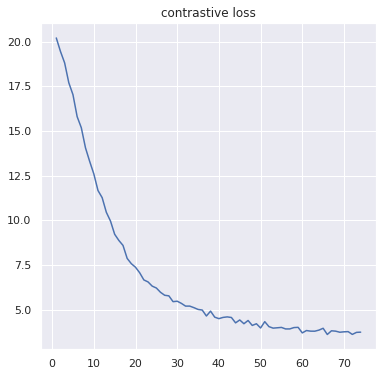

In [21]:
fig = plt.figure(figsize=(6, 6))
contr_ax = plt.subplot()
contr_ax.set_title("contrastive loss")
sns.lineplot(x=range(1, len(cb.train_loss) + 1), y=cb.train_loss, ax=contr_ax)

fig.show()